# Fit parameters 

First we optimize the parameters for the different force functions so that they all have a relaxation time of one hour. 

Then, we want to fit the force functions such that they agree as good as possible in magnitude over different regimes. We take the cubic force law fitted to a relaxation time of one hour as a baseline and fit the PWQ and GLS to it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import cbmos_serial as cbmos
import force_functions as ff
import euler_forward as ef
import cell as cl


plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6.75, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Parameter settings such that relaxation time t=1.0h

In [2]:
# Simulation parameters
tf = 1.0  # final time
N_data = 100 # number of saved data points
dt = 1/N_data  # fixed time step for Euler forward method
dim = 1

In [3]:
cell_list = [cl.Cell(0, [0.], proliferating=False), cl.Cell(1, [0.3], proliferating=False)]
t_data = np.linspace(0, tf, N_data)

In [4]:
# Solvers using different force functions 
solver_gls = cbmos.CBMSolver(ff.gls, scpi.solve_ivp, dim)
solver_cubic = cbmos.CBMSolver(ff.cubic, scpi.solve_ivp, dim)
solver_poly = cbmos.CBMSolver(ff.piecewise_polynomial, scpi.solve_ivp, dim)

In [5]:
def opt_cubic(mu):
    history = solver_cubic.simulate(cell_list, t_data, {'mu': mu}, {})
    y = np.array([c.position for c in history[-1]])
    return abs(0.99 - np.abs(y[1] - y[0]))

mu_cubic_opt = minimize(opt_cubic, 1.0, method='BFGS', options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 111
         Gradient evaluations: 37


In [6]:
mu_cubic_opt.x

array([5.70460061])

In [7]:
def opt_gls(mu):
    history = solver_gls.simulate(cell_list, t_data,{'mu': mu}, {})
    y = np.array([c.position for c in history[-1]])
    return abs(0.99 - np.abs(y[1] - y[0]))

mu_gls_opt = minimize(opt_gls, 1.0, method='Nelder-Mead', options={ 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 34


In [8]:
mu_gls_opt.x

array([1.94121094])

In [9]:
def opt_pw_poly(p):
    muR = p[0]
    ratio = p[1]
    muA = ratio*muR 
    rR = 1.0/(1.0-np.sqrt(ratio)/3.0)
    history = solver_poly.simulate(cell_list, t_data, {'muA': muA, 'muR': muR, 'rR': rR,}, {})
    y = np.array([c.position for c in history[-1]])
    return abs(0.99 - np.abs(y[1] - y[0]))


muA_poly_opt = minimize(opt_pw_poly, [1.0, 0.46], method='L-BFGS-B', bounds=((0,None), (0,None)), options={'disp': True})

In [10]:
muA_poly_opt.x

array([9.09564593, 0.21198749])

## Fit over the repulsive regime

In [11]:
rA = 1.5
s = 1.0
r0 = 0.3
params_cubic = {'mu': 5.70, 'rA': rA, 's': s}

In [12]:
r = np.linspace(r0, s, 1001)

### GLS

In [13]:
def opt_GLS(mu):
    return np.linalg.norm(ff.cubic(r, **params_cubic) - ff.gls(r, **{'mu': mu, 'a': -2*np.log(0.002/mu), 'rA': rA, 's': s}))

mu_GLS_opt = minimize(opt_GLS, 5.0, method='BFGS', options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: 10.151880
         Iterations: 5
         Function evaluations: 18
         Gradient evaluations: 6


In [14]:
mu_GLS_opt.x

array([4.27285779])

In [15]:
def opt_GLS(p):
    mu = p[0]
    a = p[1]
    return np.linalg.norm(ff.cubic(r, **params_cubic) - ff.gls(r, **{'mu': mu, 'a': a, 'rA': rA, 's': s}))

mu_GLS_opt = minimize(opt_GLS, [5.0, 5.0], method='BFGS', options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: 10.151880
         Iterations: 5
         Function evaluations: 24
         Gradient evaluations: 6


In [16]:
mu_GLS_opt.x

array([4.27285779, 5.        ])

(Here alpha of course has no effect, since we're only considering the repulsive regime.)

### PWQ

In [17]:
def opt_PWQ(p):
    muR = p[0]
    ratio = p[1]
    muA = ratio*muR
    rR = 1.0/(1.-np.sqrt(ratio)/3.0)
    params_pwq = {'muR': muR, 'muA': muA, 'rR': rR, 'rA': rA, 'n':1, 'p': 1}
    return np.linalg.norm(ff.cubic(r, **params_cubic) - ff.piecewise_polynomial(r, **params_pwq))

bounds = ((0, None), (0, None))
mu_PWQ_opt = minimize(opt_PWQ, np.array([12.0, 0.5]), method='L-BFGS-B', bounds=bounds, options={})

In [18]:
mu_PWQ_opt.x

array([1.13496715e+01, 1.79125519e-03])

In [19]:
mu_PWQ_opt.fun

1.5605839285449725

## Over the whole regime

In [20]:
r = np.linspace(r0, rA, 1001)

### GLS

In [21]:
def opt_GLS(mu):
    return np.linalg.norm(ff.cubic(r, **params_cubic) - ff.gls(r, **{'mu': mu, 'a': -2*np.log(0.002/mu), 'rA': rA, 's': s}))

mu_GLS_opt = minimize(opt_GLS, 5.0, method='BFGS', options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: 7.803572
         Iterations: 5
         Function evaluations: 18
         Gradient evaluations: 6


In [22]:
mu_GLS_opt.x

array([4.27361666])

In [23]:
def opt_GLS_large_cutoff(mu):
    return np.linalg.norm(ff.cubic(r, **params_cubic) - ff.gls(r, **{'mu': mu, 'a': 5.0, 'rA': rA, 's': s}))

mu_GLS_lc = minimize(opt_GLS_large_cutoff, 5.0, method='BFGS', options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: 8.672014
         Iterations: 5
         Function evaluations: 18
         Gradient evaluations: 6


In [24]:
mu_GLS_lc.x

array([4.25086958])

In [25]:
def opt_GLS(p):
    mu = p[0]
    a = p[1]
    return np.linalg.norm(ff.cubic(r, **params_cubic) - ff.gls(r, **{'mu': mu, 'a': a, 'rA': rA, 's': s}))

mu_GLS_opt = minimize(opt_GLS, [5.0, 5.0], method='BFGS', options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: 7.781141
         Iterations: 13
         Function evaluations: 56
         Gradient evaluations: 14


In [26]:
mu_GLS_opt.x

array([ 4.27308455, 11.40583337])

In [27]:
def opt_GLS_a_only(a):
    mu = 1.95
    return np.linalg.norm(ff.cubic(r, **params_cubic) - ff.gls(r, **{'mu': mu, 'a': a, 'rA': rA, 's': s}))

mu_GLS_opt = minimize(opt_GLS_a_only, 5.0, method='BFGS', options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: 34.005746
         Iterations: 7
         Function evaluations: 30
         Gradient evaluations: 10


In [28]:
mu_GLS_opt.x

array([7.50978648])

### PWQ

In [29]:
def opt_PWQ(p):
    muR = p[0]
    ratio = p[1]
    muA = ratio*muR
    rR = 1.0/(1.-np.sqrt(ratio)/3.0)
    params_pwq = {'muR': muR, 'muA': muA, 'rR': rR, 'rA': rA, 'n':1, 'p': 1}
    return np.linalg.norm(ff.cubic(r, **params_cubic) - ff.piecewise_polynomial(r, **params_pwq))

bounds = ((0, None), (0, None))
mu_PWQ_opt = minimize(opt_PWQ, np.array([12.0, 0.5]), method='L-BFGS-B', bounds=bounds, options={'gtol': 1e-5, 'disp': True})

In [30]:
mu_PWQ_opt.x

array([1.13328915e+01, 2.14391583e-03])

In [31]:
mu_PWQ_opt.fun

1.8413483940059712

## Over the adhesive regime

In [32]:
r = np.linspace(s, rA, 1001)

### GLS

In [33]:
def opt_GLS(mu):
    return np.linalg.norm(ff.cubic(r, **params_cubic) - ff.gls(r, **{'mu': mu, 'a': -2*np.log(0.002/mu), 'rA': rA, 's': s}))

mu_GLS_opt = minimize(opt_GLS, 5.0, method='BFGS', options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: 1.297399
         Iterations: 4
         Function evaluations: 18
         Gradient evaluations: 6


In [34]:
mu_GLS_opt.x

array([4.34307366])

In [35]:
def opt_GLS_large_cutoff(mu):
    return np.linalg.norm(ff.cubic(r, **params_cubic) - ff.gls(r, **{'mu': mu, 'a': 5.0, 'rA': rA, 's': s}))

mu_GLS_lc = minimize(opt_GLS_large_cutoff, 5.0, method='BFGS', options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.843968
         Iterations: 7
         Function evaluations: 33
         Gradient evaluations: 11


In [36]:
mu_GLS_lc.x

array([1.08521141])

In [37]:
def opt_GLS(p):
    mu = p[0]
    a = p[1]
    return np.linalg.norm(ff.cubic(r, **params_cubic) - ff.gls(r, **{'mu': mu, 'a': a, 'rA': rA, 's': s}))

mu_GLS_opt = minimize(opt_GLS, [5.0, 5.0], method='BFGS', options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.407123
         Iterations: 10
         Function evaluations: 48
         Gradient evaluations: 12


In [38]:
mu_GLS_opt.x

array([2.18026832, 7.94611768])

In [39]:
def opt_GLS_a_only(a):
    mu = 1.95
    return np.linalg.norm(ff.cubic(r, **params_cubic) - ff.gls(r, **{'mu': mu, 'a': a, 'rA': rA, 's': s}))

mu_GLS_opt = minimize(opt_GLS_a_only, 5.0, method='BFGS', options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.424737
         Iterations: 7
         Function evaluations: 24
         Gradient evaluations: 8


In [40]:
mu_GLS_opt.x

array([7.51041169])

### PWQ

In [41]:
def opt_PWQ(p):
    muR = p[0]
    ratio = p[1]
    muA = ratio*muR
    rR = 1.0/(1.-np.sqrt(ratio)/3.0)
    params_pwq = {'muR': muR, 'muA': muA, 'rR': rR, 'rA': rA, 'n':1, 'p': 1}
    return np.linalg.norm(ff.cubic(r, **params_cubic) - ff.piecewise_polynomial(r, **params_pwq))

bounds = ((0, None), (0, None))
mu_PWQ_opt = minimize(opt_PWQ, np.array([12.0, 0.5]), method='L-BFGS-B', bounds=bounds, options={'gtol': 1e-5, 'disp': True})

In [42]:
mu_PWQ_opt.x

array([8.13262893, 0.46188713])

In [43]:
mu_PWQ_opt.fun

0.15626552059122797

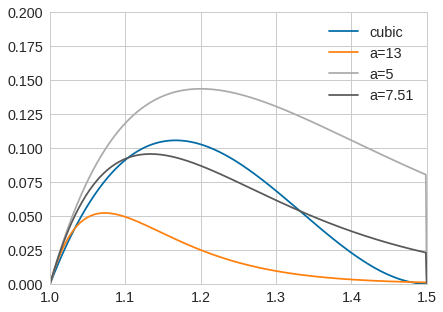

In [47]:
plt.plot(np.linspace(0.3, 1.5, 1001), ff.cubic(np.linspace(0.3, 1.5, 1001),**params_cubic), label='cubic')
mu_GLS = 1.95
plt.plot(np.linspace(0.3, 1.5, 1001), ff.gls(np.linspace(0.3, 1.5, 1001), **{'mu': mu_GLS, 'a': -2*np.log(0.002/mu_GLS), 'rA': rA, 's': s}), label='a=13')
plt.plot(np.linspace(0.3, 1.5, 1001), ff.gls(np.linspace(0.3, 1.5, 1001), **{'mu': mu_GLS, 'a': 5.0, 'rA': rA, 's': s}), label='a=5')
plt.plot(np.linspace(0.3, 1.5, 1001), ff.gls(np.linspace(0.3, 1.5, 1001), **{'mu': mu_GLS, 'a': 7.51, 'rA': rA, 's': s}), label='a=7.51')

plt.xlim((1.0, 1.5))
plt.ylim((0, 0.20))
plt.legend()